In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/Capstone1006_FA23/CKA_Analysis_MNIST/
%ls

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1NBUiaEfcN4sFm5VZHTlmo3t5NuD8Qw_W/Capstone1006_FA23/CKA_Analysis_MNIST
 analysis.py                           MNIST_framework.py
'CKA Analysis - GPU.ipynb'             MNIST.ipynb
'CKA Analysis.ipynb'                  'MNIST Low-Acc Cindy.ipynb'
 CKA_analysis_pytorch.ipynb           'MNIST Low-Acc.ipynb'
 CKA_analysis_pytorch_perBatch.ipynb  'MNIST New_Loss_CKA_manual.ipynb'
 CKA_Heatmap_Net10.png                'MNIST New_Loss_CKA_pytorch.ipynb'
 CKA_Heatmap_Net4.png                 'MNIST New_Loss_CKA_tensorflow.ipynb'
 CKA.py                               'MNIST New_Loss_CKA_w oPC.ipynb'
 efficient_CKA.py                     'MNIST New_Loss + Original_Loss.ipynb'
 mnist10_73.pt                         MNIST_Training/
 mnist_10.pt                           __pycache__/
 mnist_4.pt                            pytorch_CKA_perBatch.py
'MNIST CKA_HSIC0.ipynb'                pytorch_CKA.py
 MNIST_framework_new.py           

In [ ]:
from MNIST_framework_new import *

from __future__ import print_function
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.autograd import Variable
import os
import numpy as np
import pickle
from scipy.spatial.distance import cosine
import random
import math
import time
from google.colab import files

torch.set_default_tensor_type(torch.DoubleTensor)

/usr/local/lib/python3.10/dist-packages/torch/__init__.py:614: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


# CKA loss

In [ ]:
class CKA_Loss(torch.nn.Module):
    def __init__(self):
        super(CKA_Loss,self).__init__()

    def HSIC(self, K, L, device = "cuda"):
        """
        Computes the unbiased estimate of HSIC metric.
        """
        M = K.shape[0]
        I = torch.eye(M).to(device)
        unit = torch.ones([M, M]).to(device)
        H = I - unit/M
        Khat = H @ K @ H
        Lhat = H @ L @ H
        return torch.abs(torch.sum(Khat * Lhat))

    def forward(self, output, device = "cuda", test = False):
        M = len(output)
        hsic_matrix = torch.zeros(M, M)
        for i in range(M):
            X = output[i].flatten(1)
            K = X @ X.t()
            K.fill_diagonal_(0.0)
            hsic_k = self.HSIC(K, K)
            for j in range(M):
                Y = output[j].flatten(1)
                L = Y @ Y.t()
                L.fill_diagonal_(0.0)
                assert K.shape == L.shape, f"Feature shape mismatch! {K.shape}, {L.shape}"
                hsic_matrix[i, j] = self.HSIC(K, L) / torch.sqrt(hsic_k *self.HSIC(L, L)+1e-06)
        # absolute sum of differ
        id = torch.eye(M)
        hsic_upper = torch.tril(hsic_matrix)
        l = torch.sum(torch.abs(hsic_upper - id))
        return hsic_matrix,l

# Training & Testing Function


In [ ]:
def train(model, device, train_loader, optimizer,CKA_index):
    model.train()
    history = []
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        output = model(data) # output is a length-10 tuple for 10 layers outputs
        optimizer.zero_grad()
        criterion = CKA_Loss()
        _,loss = criterion([output[idx] for idx in CKA_index], device)
        history.append(loss)
        if torch.isnan(loss):
            break
        loss.backward()
        optimizer.step()

    return history

In [ ]:
def plotHeatmap(heatmap, index):
    plt.imshow(np.flipud(heatmap), cmap='magma', interpolation='nearest', vmin=0.0, vmax=1.0)
    plt.colorbar(label='Similarity')
    plt.title('CKA')
    plt.xlabel('Layer')
    plt.ylabel('Layer')
    plt.xticks(ticks=np.arange(0, heatmap.shape[0]), labels=index)
    plt.yticks(ticks=np.arange(heatmap.shape[0]-1,-1,-1), labels=index)
    plt.tight_layout()
    plt.show()

In [ ]:
def test(model, device, test_loader,CKA_index):
    model.eval()
    nll_loss = 0
    cka_sub_loss = 0
    cka_loss = 0
    correct = 0
    m_sub = np.zeros((len(CKA_index),len(CKA_index)))
    m = np.zeros((10,10))
    model.cuda()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            nll_loss += F.nll_loss(output[-1], target, reduction='sum').item()  # sum up batch loss

            criterion = CKA_Loss()
            matrix, loss= criterion([output[idx] for idx in CKA_index], device)
            cka_sub_loss += loss.item()
            m_sub += matrix.detach().numpy().reshape((len(CKA_index),len(CKA_index)))
            matrix2, loss2= criterion(output[:10], device)
            cka_loss += loss2.item()
            m += matrix2.detach().numpy().reshape((10,10))

            pred = output[-1].argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    nll_loss /= len(test_loader)
    cka_loss /= len(test_loader)
    cka_sub_loss /= len(test_loader)
    m /= len(test_loader)
    m_sub /= len(test_loader)
    plotHeatmap(m, list(range(10)))
    plotHeatmap(m_sub, CKA_index)
    acc = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average NLL loss: {:.4f}, Average CKA loss: {:.4f}, {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        nll_loss, cka_loss, cka_sub_loss, correct, len(test_loader.dataset),  acc))
    return cka_loss,acc

#Training Process

In [ ]:
# Training settings
torch.manual_seed(1122)
device = torch.device("cuda")
train_kwargs = {'batch_size': 64}
test_kwargs = {'batch_size': 64}
cuda_kwargs = {'num_workers': 1,'pin_memory': True,'shuffle': True}
train_kwargs.update(cuda_kwargs)
test_kwargs.update(cuda_kwargs)
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))])
dataset1 = datasets.MNIST('../data', train=True, download=True, transform=transform)
dataset2 = datasets.MNIST('../data', train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

In [ ]:
model_init = torch.load('MNIST_Training/mnist10_epoch_2.pt').double()

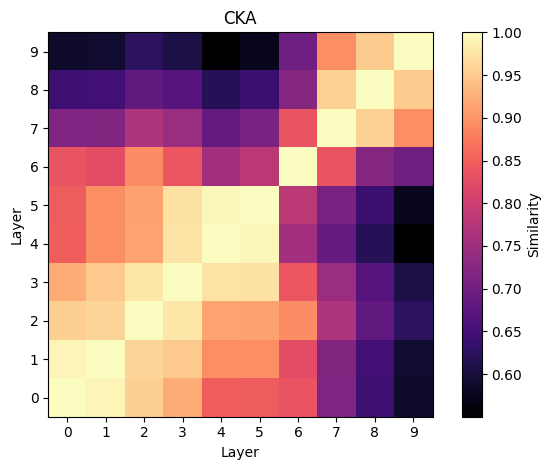

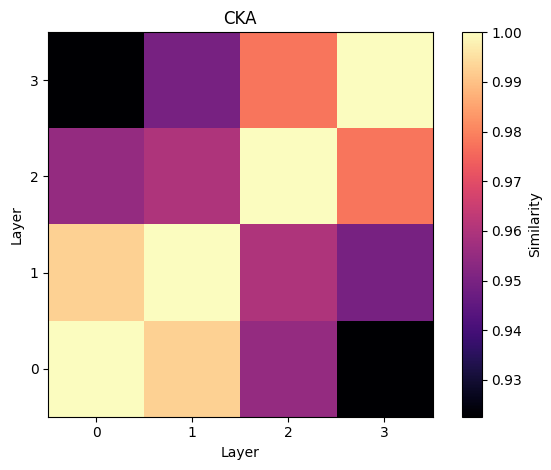


Test set: Average NLL loss: 17.1857, Average CKA loss: 35.7786, 5.7576, Accuracy: 9121/10000 (91%)



In [ ]:
CKA_index = [0,1,2,3]
_,_ = test(model_init, device, test_loader, CKA_index)

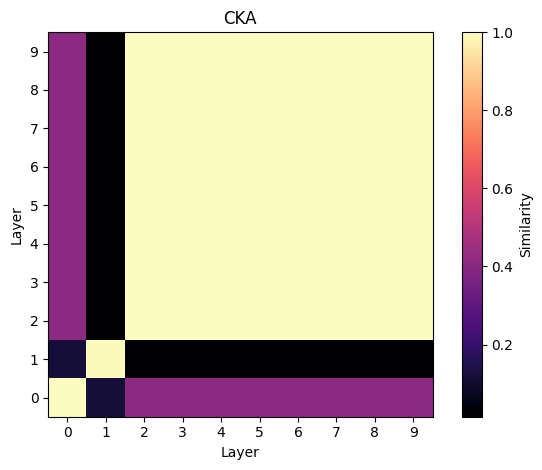

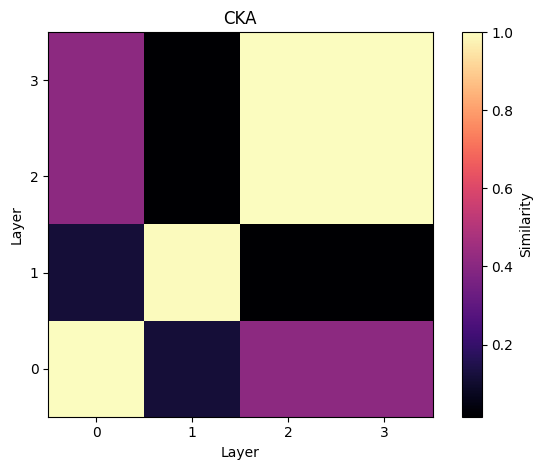


Test set: Average NLL loss: 674.6713, Average CKA loss: 31.5278, 1.9727, Accuracy: 1135/10000 (11%)



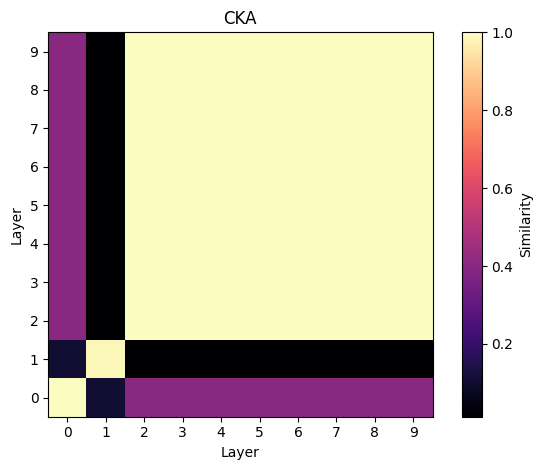

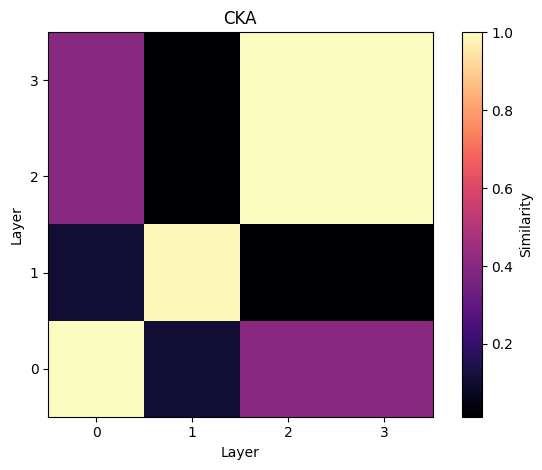


Test set: Average NLL loss: 676.1569, Average CKA loss: 31.4438, 1.9520, Accuracy: 1135/10000 (11%)



KeyboardInterrupt: ignored

In [ ]:
optimizer = optim.Adadelta(model_init.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9)
loss = []
acc = []
history_epoch = []
time_batch = 0
for epoch in range(3):
    start_time = time.time()
    history = train(model_init, device, train_loader, optimizer,CKA_index)
    assert len(history) == len(train_loader), "Nan with batch {}".format(len(history))
    l,a = test(model_init, device, test_loader,CKA_index)
    loss.append(l)
    acc.append(a)
    scheduler.step()
    history_epoch.append(history)
    time_batch += time.time()-start_time
print(time_batch/3)

Text(0.5, 1.0, 'CKA loss per batch')

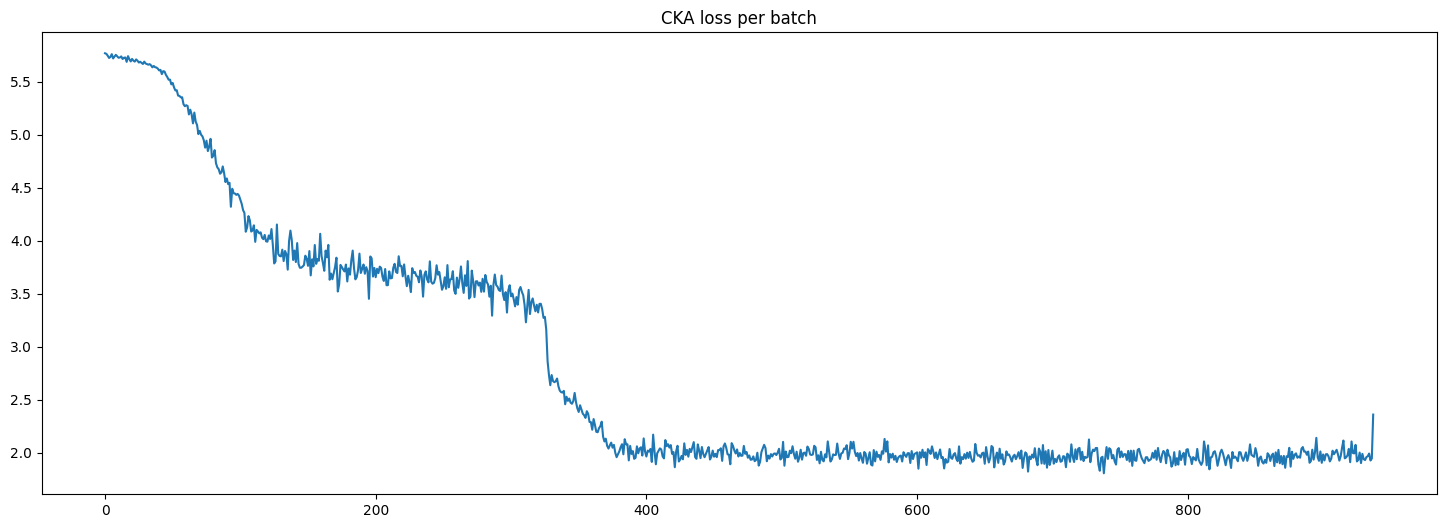

In [ ]:
# plot for CKA loss term on training process per batch
ll = history_epoch[0]
# for i in range(1,len(history_epoch)):
#   ll = ll+ history_epoch[i]

plt.figure(figsize = (18,6))
plt.plot([h.detach().numpy() for h in ll])
plt.title("CKA loss per batch")